In [15]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.constants as sci
from scipy.optimize import curve_fit
plt.rcParams["font.family"] = "Arial"
DPI = 300
Z = 22
TEMP = 310
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['axes.linewidth'] = 1.4
from scipy.interpolate import Rbf
from svg2emf import svg2emf

In [2]:
np_labels = ["N8", "N16", "N24", "N32", "N40", "N48", "N56", "N64", "N72", "N80", "N88", "N96", "N104"]
ion_labels = ["I0", "I10", "I20", "I50", "I90", "I150"]
q_vals = [8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104]
q_vals = np.array(q_vals)/21.24 #4pi(1.3)^2
center_q_vals = np.round((q_vals[1:][::2]+q_vals[:-1][::2])/2,1)
n_q_show = len(center_q_vals)
i_vals = [0, 30, 70, 170, 300, 500]
n_ion = len(i_vals)
n_np = len(q_vals)
c_np = cm.Blues(np.linspace(0.3, 1, len(np_labels)))
c_ion = cm.YlOrRd(np.linspace(0.3, 1, len(ion_labels)))

In [3]:
def read_file(fname):
    f = open(fname)
    fl = f.readlines()
    f.close()
    data = []
    for line in fl:
        if "@" not in line and "#" not in line:
            data.append(line.split())
    data = np.array(data, dtype='float')
    return data

def debye_huckel(x, A, B, C):
    return A*np.divide(np.exp(-B*x), x) + C

In [4]:
POTs = []
RDFs = []
for nl in np_labels:
    pot_np = []
    rdf_np = []
    for ion in ion_labels:
        pot = read_file("POTENTIAL/T1-{}-{}_L_PRO1_pot.sfu".format(nl, ion))
        pot_np.append(pot)
        rdf = read_file("RDF/T1-{}-{}_L_PRO1_rdf.sfu".format(nl, ion))
        rdf_np.append(rdf)
    POTs.append(pot_np)
    RDFs.append(rdf_np)
POTs = np.array(POTs)
RDFs = np.array(RDFs)
print(np.shape(POTs))
print(np.shape(RDFs))

(13, 6, 249, 6)
(13, 6, 249, 4)


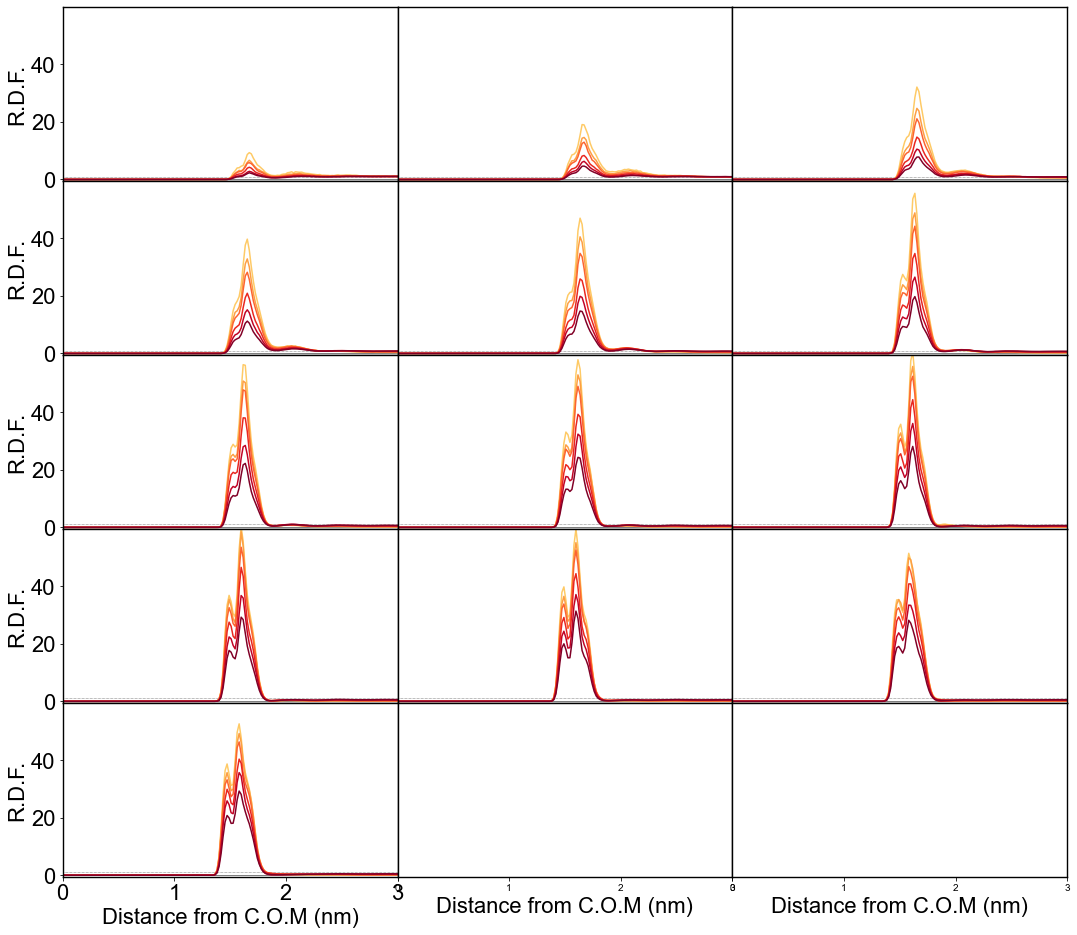

In [5]:
Xini = 0
Xfin = 3
Xticks = np.linspace(Xini, Xfin, 4, dtype='float')
plot_ndx = 1 #1 is NA
subplot_kw = {'xlim':(Xini, Xfin), 'ylim':(-0.5, 60), 'xticks':[], 'yticks':[]}
fig, axs = plt.subplots(figsize=(18,16), ncols=3, nrows=5, subplot_kw=subplot_kw, gridspec_kw={'hspace':0.0, 'wspace':0.0})
for ax, rdf_np in zip(axs.flatten(), RDFs):
    ax.tick_params(labelsize=Z)
    ax.axhline(0, xmin=0, xmax=1, lw=0.5, c='k')
    ax.axhline(1, xmin=0, xmax=1, lw=0.5, c='k', ls=":")
    for rdf, c in zip(rdf_np, c_ion):
        ax.plot(rdf[:,0], rdf[:,plot_ndx], c=c)
for ax in axs[-1,:]:
    ax.set_xticks(Xticks)
    ax.set_xlabel("Distance from C.O.M (nm)", fontsize=Z)
for ax in axs[:,0]:
    ax.set_ylabel("R.D.F.", fontsize=Z)
    ax.set_yticks([0, 20, 40])
plt.show()
plt.close()

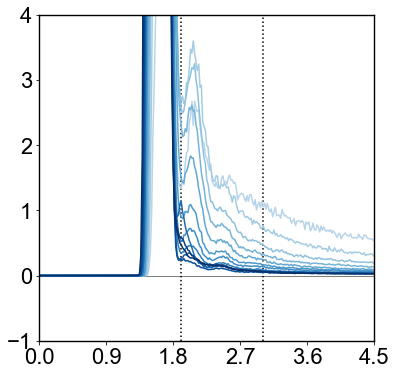

In [6]:
Xinifit = 1.9
Xfinfit = 3
plt_ndx = 1 #1 is for NA
Xini = 0
Xfin = 4.5
Xticks = np.linspace(Xini, Xfin, 6, dtype='float')
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.tick_params(labelsize=Z)
ax.set_xticks(Xticks)
ax.set_xlim(Xini, Xfin)
ax.axvline(Xinifit, lw=1.5, c='k', ls=":")
ax.axvline(Xfinfit, lw=1.5, c='k', ls=":")
ax.axhline(0, lw=0.5, c='k')
ax.set_ylim(-1, 4)
for rdf_np, c in zip(RDFs, c_np):
    ax.plot(rdf_np[0,:,0], rdf_np[0,:,plot_ndx], c=c)
plt.show()
plt.close()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\lines.py:1253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.any(self._markerfacecolor != fc):
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\lines.py:1253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.any(self._markerfacecolor != fc):
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\lines.py:1253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.any(self._markerfacecolor != fc):
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\lines.py:1253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.any(self._markerfacecolor != fc):
C:\ProgramData\Anaconda3\lib\site-packages\matplotli

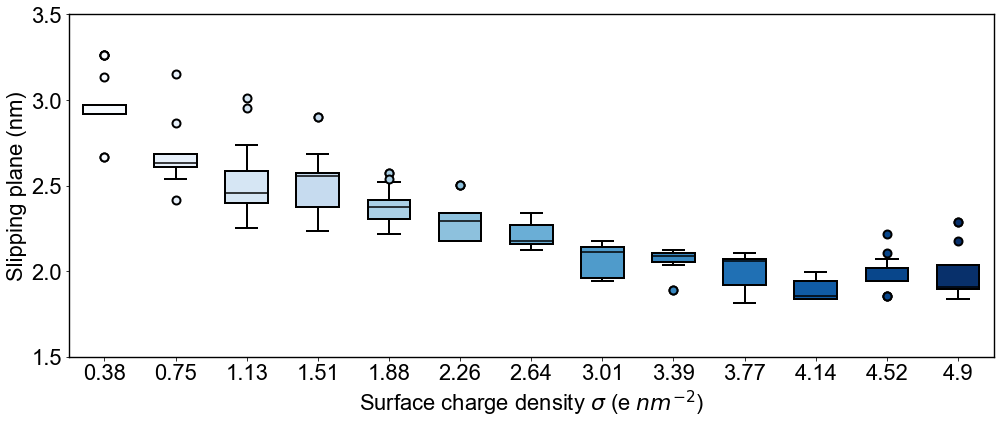

[2.919, 2.63, 2.458, 2.557, 2.377, 2.295, 2.178, 2.114, 2.087, 2.06, 1.852, 2.015, 1.907]


In [17]:
subplot_kw={'xlim':(0,4.5), 'ylim':(-1,3), 'xticks':[], 'yticks':[]}
fig, axs = plt.subplots(figsize=(18, 16), ncols=3, nrows=5, subplot_kw=subplot_kw, gridspec_kw={'hspace':0.0, 'wspace':0.0})
space_fit_min = np.linspace(Xinifit, Xfinfit, 20)
x_shears = []
all_params = []
for (r, rdf_np), c, ax in zip(enumerate(RDFs), c_np, axs.flatten()):
    rdf = rdf_np[0,:,:]
    x_shear = []
    ax.tick_params(labelsize=Z)
    ax.axhline(0, lw=0.5, c='k')
    ax.axvline(Xinifit, lw=1.5, c='k', ls=":")
    ax.axvline(Xfinfit, lw=1.5, c='k', ls=":")
    for x_min in space_fit_min:
        in_range = rdf[:,0] >= x_min
        space_sample = rdf[in_range,0]
        rdf_sample = rdf[in_range,1]
        opt_params, cov = curve_fit(debye_huckel, xdata=space_sample, ydata=rdf_sample, p0=[26.4, 1.5, 0.06])#Guess from previous fits
        all_params.append(opt_params)
        y_pred = debye_huckel(rdf[:,0], *opt_params)
        diff = np.abs(rdf[:,1] - y_pred)
        ndx_shear = np.where(diff>0.1)[0][-1]
        x_shear.append(rdf[ndx_shear,0])
        ax.plot(space_sample, debye_huckel(space_sample, *opt_params))
    x_shears.append(x_shear)
    ax.plot(rdf[:,0], rdf[:,1], c=c, label=r"$D_s$={:.2f} nm".format(np.median(x_shear)), zorder=0)
    ax.legend(fontsize=Z-4, loc='upper left')
for ax in axs[-1,:]:
    ax.set_xlabel("Distance from C.O.M (nm)", fontsize=Z)
    ax.set_xticks(np.linspace(0,4,5))
for ax in axs[:,0]:
    ax.set_ylabel("R.D.F", fontsize=Z)
    ax.set_yticks(np.linspace(0,3,4))
#plt.show()
plt.close()

bp = dict(linestyle='-', lw=2, color='k', facecolor='r')
fp = dict(marker='o', ms=8, ls='none', mec='k', mew=2)
mp = dict(ls='-', lw=1.5,color='k')
cp = dict(ls='-', lw=2, color='k')
wp = dict(ls='-', lw=2, color='k')

faded_ion_colors = cm.Blues(np.linspace(0, 1, len(q_vals)))

fig = plt.figure(figsize=(14,6))
ax = plt.axes()
ax.tick_params(labelsize=Z)
ax.set_ylim(1.5, 3.5)
for i, q in enumerate(q_vals):
    bpl = ax.boxplot(x_shears[i], positions=[i], labels=[np.round(q,2)], widths=0.6, whis=1, patch_artist=True, boxprops=bp, flierprops=fp, medianprops=mp, capprops=cp, whiskerprops=wp)
    bpl['boxes'][0].set_facecolor(faded_ion_colors[i])
    bpl['fliers'][0].set_markerfacecolor(faded_ion_colors[i])
ax.set_xlabel(r"Surface charge density $\sigma$ (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Slipping plane (nm)", fontsize=Z)
plt.tight_layout()
plt.savefig("Shearingplanes.svg", dpi=300, format='svg', bbox_inches='tight')
svg2emf(r"Shearingplanes.svg")
plt.show()
plt.close()
shear_planes = [np.median(x) for x in x_shears]
print(shear_planes)

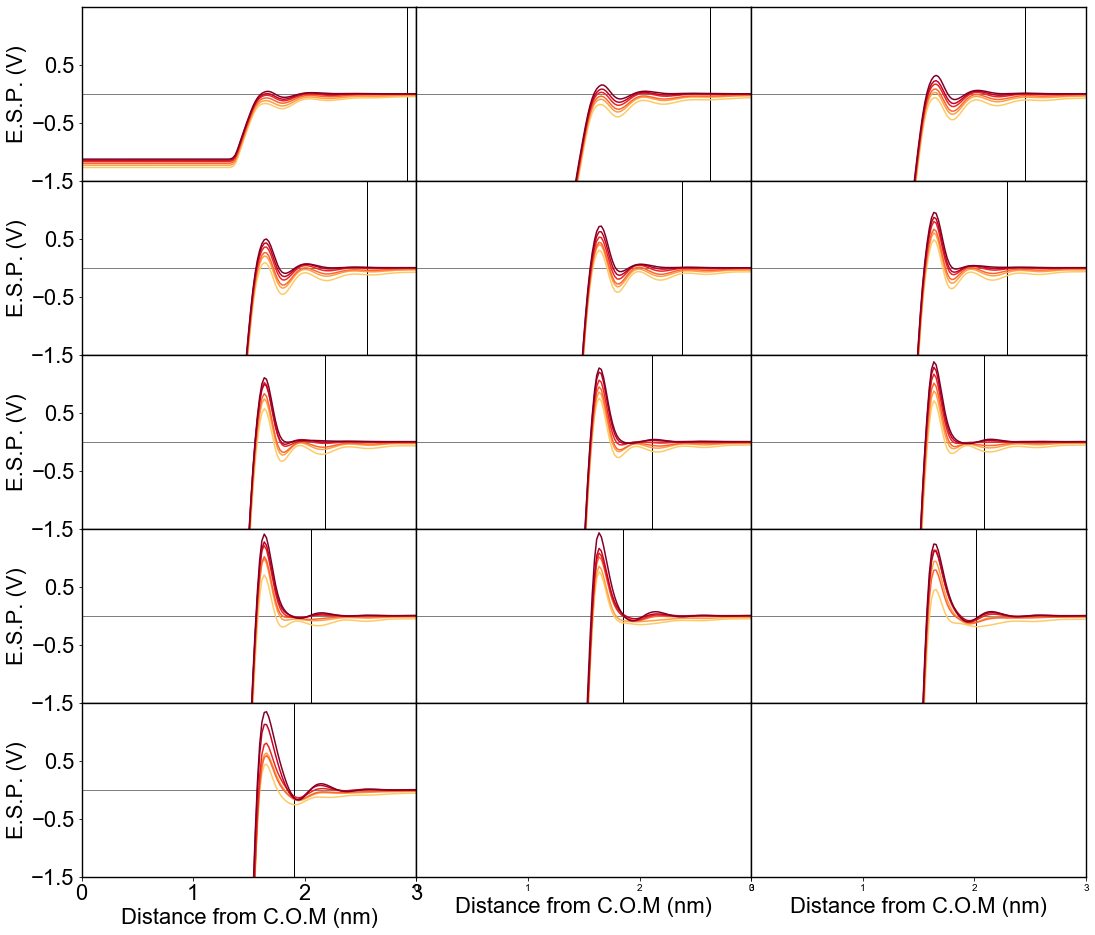

In [8]:
Xini = 0
Xfin = 3
Xticks = np.linspace(Xini, Xfin, 4)
plot_ndx = -1 #-1 is Total
subplot_kw = {'xlim':(Xini, Xfin), 'ylim':(-1.5, 1.5), 'xticks':[], 'yticks':[]}
fig, axs = plt.subplots(figsize=(18,16), ncols=3, nrows=5, subplot_kw=subplot_kw, gridspec_kw={'hspace':0.0, 'wspace':0.0})
for ax, pot_np, s_plane in zip(axs.flatten(), POTs, shear_planes):
    ax.tick_params(labelsize=Z)
    ax.axhline(0, xmin=0, xmax=1, lw=0.5, c='k')
    ax.axvline(s_plane, ymin=0, ymax=1, lw=1.0, c='k')
    for pot, c in zip(pot_np, c_ion):
        ax.plot(pot[:,0], pot[:,plot_ndx], c=c)
for ax in axs[-1,:]:
    ax.set_xticks(Xticks)
    ax.set_xlabel("Distance from C.O.M (nm)", fontsize=Z)
for ax in axs[:,0]:
    ax.set_ylabel("E.S.P. (V)", fontsize=Z)
    ax.set_yticks([-1.5, -0.5, 0.5])
plt.show()
plt.close()

In [9]:
zeta_pots = [[pot[np.argmin(np.abs(pot[:,0] - x)),-1] for pot in pot_np] for x, pot_np in zip(shear_planes, POTs)]
zeta_pots = np.array(zeta_pots)*1000
print(zeta_pots)
zeta_pots_copy = np.zeros((n_np+1, n_ion))
zeta_pots_copy[1:,:] = zeta_pots
zeta_pots = zeta_pots_copy*1
print(np.shape(zeta_pots), np.min(zeta_pots), np.max(zeta_pots))
print(zeta_pots)

[[-4.750e+01 -2.750e+01 -1.150e+01 -4.400e+00  5.000e-01  1.900e+00]
 [-1.026e+02 -5.540e+01 -3.870e+01 -9.800e+00 -9.000e-01  6.600e+00]
 [-1.045e+02 -5.660e+01 -3.000e+01 -5.100e+00  4.000e+00  1.340e+01]
 [-1.198e+02 -6.570e+01 -4.220e+01 -8.500e+00  4.000e+00  7.800e+00]
 [-9.850e+01 -5.690e+01 -3.350e+01 -7.300e+00  4.500e+00  9.000e+00]
 [-1.307e+02 -7.710e+01 -4.670e+01 -1.410e+01 -1.600e+00  9.500e+00]
 [-2.101e+02 -1.296e+02 -9.240e+01 -2.670e+01 -4.900e+00  1.640e+01]
 [-1.654e+02 -1.021e+02 -6.330e+01 -1.450e+01  2.270e+01  3.980e+01]
 [-1.606e+02 -9.510e+01 -6.020e+01 -8.600e+00  1.330e+01  2.600e+01]
 [-1.561e+02 -8.380e+01 -6.310e+01 -5.100e+00  1.000e-01  1.270e+01]
 [-1.225e+02 -8.610e+01 -9.300e+00 -1.450e+01  2.070e+01  2.500e+00]
 [-1.875e+02 -1.157e+02 -1.156e+02 -7.470e+01 -4.770e+01 -4.320e+01]
 [-2.568e+02 -1.579e+02 -1.552e+02 -1.045e+02 -1.417e+02 -1.263e+02]]
(14, 6) -256.79999999999995 39.800000000000004
[[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+0

In [10]:
def build_zeta_map(zetas, n_pts=500, epsilon=2):
    xs = []
    ys = []
    zeta_potentials = []
    for i in range(n_np+1): #+1 to include Q=0
        for j in range(n_ion):
            xs.append(i)
            ys.append(j)
            zeta_potentials.append(zetas[i,j])
            
    #interpolation
    rbf = Rbf(xs, ys, zeta_potentials, epsilon=epsilon)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

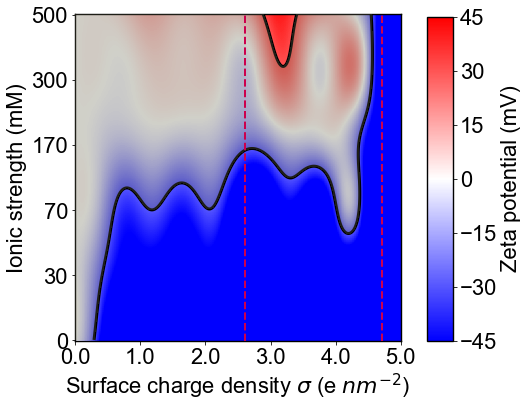

In [17]:
cmap='bwr'
sx, sy, zeta_map = build_zeta_map(zeta_pots)
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(zeta_map)-1, 6))
#ax.set_xticklabels(np.round(np.linspace(0, max(q_vals),7), 1))
ax.set_xticklabels(np.linspace(0,5,6))
ax.set_yticks(np.linspace(0, len(zeta_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.axvline(len(zeta_map)*2.6/5.0, lw=2, c=(0.8,0.0,0.3), zorder=10, ls='--')
ax.axvline(len(zeta_map)*4.7/5.0, lw=2, c=(0.8,0.0,0.3), zorder=10, ls='--')
ax.set_xlabel(r"Surface charge density $\sigma$ (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(zeta_map, cmap=cmap, vmin=-45, vmax=45, origin='lower', zorder=0)
ax.contour(zeta_map, levels=np.array([-30]), colors=[(0,0,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.contour(zeta_map, levels=np.array([30]), colors=[(0,0,0)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.contourf(zeta_map, levels=np.array([-30, 30]), colors=[(0.4,0.4,0.3)], zorder=10, origin='lower', alpha=0.3)
a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[-45, -30, -15, 0, 15, 30, 45])#np.linspace(-50, 50, 7, dtype=int))
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Zeta potential (mV)", fontsize=Z)
plt.savefig("Zetamap.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

In [12]:
print(np.mean(zeta_map[sx/12*4.9 > 4.1]))

-71.50417451336442


In [13]:
np.savetxt("Zetamap.csv", zeta_map, delimiter=',')